# "제주도 도로 교통량 예측 AI 경진대회"
> "제주도 도로 교통량 예측 AI 경진대회"

- toc:true
- branch: master
- badges: true
- comments: true
- author: jaeeon
- categories: [colab, python]

# 제주도 도로 교통량 예측 AI 경진대회

[대회 링크](https://dacon.io/competitions/official/235985/data)

**배경**

제주도내 주민등록인구는 2022년 기준 약 68만명으로, 연평균 1.3%정도 매년 증가하고 있다.

또한 외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정되며, 

제주도민 증가와 외국인의 증가로 현재 제주도의 교통체증이 심각한 문제로 떠오르고 있다.

**목적**

제주도의 교통 정보 데이터로부터 도로 교통량을 예측해보고자 한다.



---

## 목차
- [01 Library & Settings](#01-library-and-settings)
- [02 Data Import](#02-data-import)
- [03 EDA](#03-eda)
  * [변수 확인](#variables)
- [04 Feature Engineering](#04-feature-engineering)
- [05 Data Preprocessing](#05-data-preprocessing)
- [06 Modeling](#06-modeling)
    + [Regression MLP(회귀 다층퍼셉트론)](#regression-mlp)
      - [1st Modeling](#1st-modeling)
      - [Hyperparameter Tuning](#hyperparameter-tuning)
      - [2nd Modeling](#2nd-modeling)
    + [LightGBM Regressor](#lightgbm-regressor)
    + [XGBoost](#xgboost)
- [07 Modeling Result](#07-modeling-result)  
    - [1. Regression MLP](#1-regression-mlp)  
    - [2. LightGBM Regressor](#2-lightgbm-regressor)  
    - [3. XGBoost](#3-xgboost)  
- [08 Competition Result](#08-competition-result)  

---
## 01. Library And Settings

In [14]:
# 그래프 한글 깨짐 대비
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 설치 후, 런타임 전부 재실행!!

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,278 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [1]:
### 구글 드라이브 연결 - Colab에서만 사용
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
### import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
%matplotlib inline
import seaborn as sns
sns.set()
import gc

In [3]:
plt.rc('font', family='NanumBarunGothic') 

---

## 02. Data Import

**data_info.csv**

- 데이터의 각 Column별 추가 설명


In [4]:
data_info = pd.read_csv("/content/drive/MyDrive/Competition/데이콘_제주도도로교통량예측AI경진대회/data_info.csv")
data_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


**csv to parquet**

: 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능하다

In [5]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [6]:
csv_to_parquet("/content/drive/MyDrive/Competition/데이콘_제주도도로교통량예측AI경진대회/train.csv", 'train')
csv_to_parquet('/content/drive/MyDrive/Competition/데이콘_제주도도로교통량예측AI경진대회/test.csv', 'test')

train Done.
test Done.


**Train Data Set - train.csv**
- 2022년 8월 이전 데이터만 존재 (단, 날짜가 모두 연속적이지 않음)
- 4,701,217개의 데이터
- id : 샘플 별 고유 id
- 날짜, 시간, 교통 및 도로구간 등 정보
- target : 도로의 차량 평균 속도(km)

In [7]:
train_df = pd.read_parquet('./train.parquet')
train_df.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   road_in_use            int64  
 5   lane_count             int64  
 6   road_rating            int64  
 7   road_name              object 
 8   multi_linked           int64  
 9   connect_code           int64  
 10  maximum_speed_limit    float64
 11  vehicle_restricted     float64
 12  weight_restricted      float64
 13  height_restricted      float64
 14  road_type              int64  
 15  start_node_name        object 
 16  start_latitude         float64
 17  start_longitude        float64
 18  start_turn_restricted  object 
 19  end_node_name          object 
 20  end_latitude           float64
 21  end_longitude          float64
 22  end_turn_restricte

**Test Data Set - test.csv**
- 2022년 8월 데이터만 존재 (단, 날짜가 모두 연속적이지 않음)
- 291,241개의 데이터
- id : 샘플 별 고유 id
- 날짜, 시간, 교통 및 도로구간 등 정보


In [9]:
test_df = pd.read_parquet('./test.parquet')
test_df.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,0,3,107,연삼로,0,0,...,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,0,2,103,일반국도12호선,0,0,...,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,0,1,103,일반국도16호선,0,0,...,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,0,3,103,일반국도11호선,0,0,...,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,0,3,106,번영로,0,0,...,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     291241 non-null  object 
 1   base_date              291241 non-null  int64  
 2   day_of_week            291241 non-null  object 
 3   base_hour              291241 non-null  int64  
 4   road_in_use            291241 non-null  int64  
 5   lane_count             291241 non-null  int64  
 6   road_rating            291241 non-null  int64  
 7   road_name              291241 non-null  object 
 8   multi_linked           291241 non-null  int64  
 9   connect_code           291241 non-null  int64  
 10  maximum_speed_limit    291241 non-null  float64
 11  vehicle_restricted     291241 non-null  float64
 12  weight_restricted      291241 non-null  float64
 13  height_restricted      291241 non-null  float64
 14  road_type              291241 non-nu

---

## 03. EDA


**Train Data set 변수 확인**

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


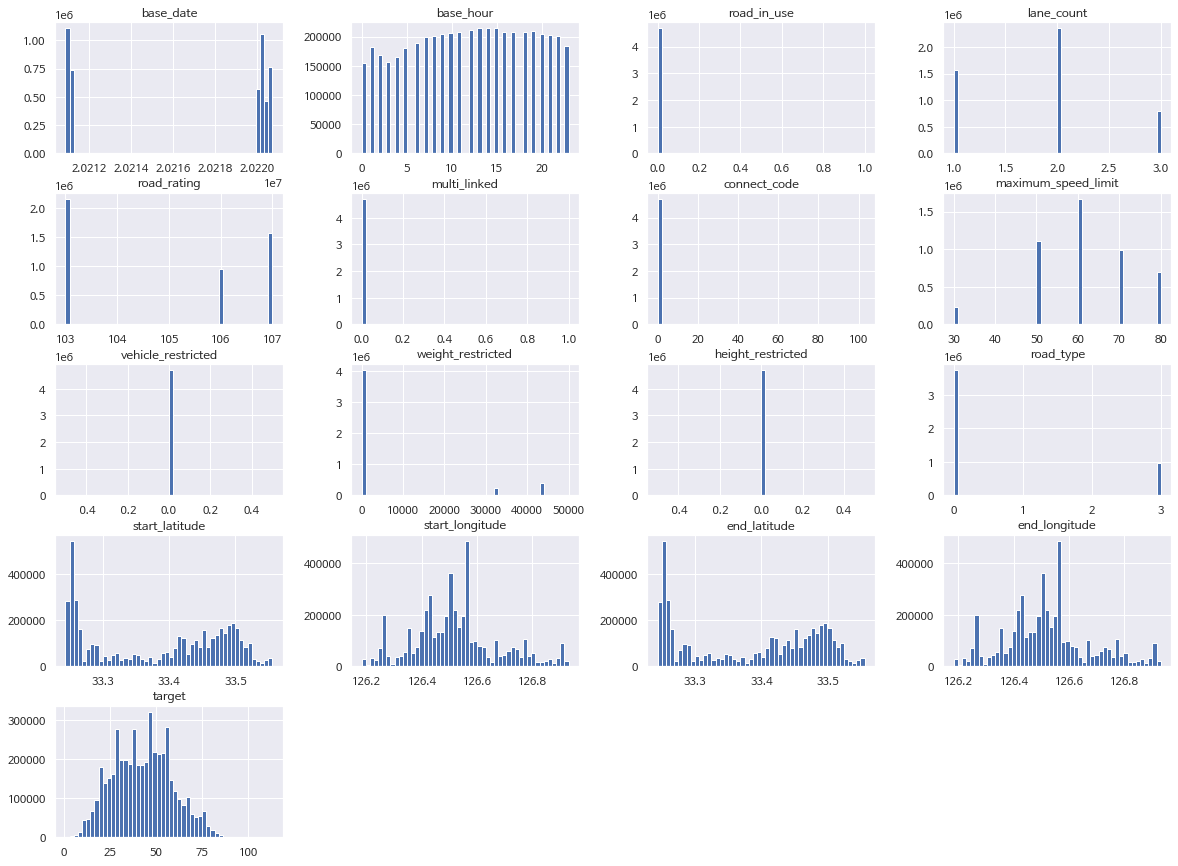

In [11]:
### 변수 확인
%matplotlib inline
import matplotlib.pyplot as plt
train_df.hist(bins=50, figsize=(20,15))
plt.show()

### Variables
- 시간 관련된 변수 확인

In [11]:
### base date를 YYYY-MM-DD형식으로 바꿈
train_df["base_date"] = pd.to_datetime(train_df["base_date"],format='%Y%m%d')
test_df["base_date"] = pd.to_datetime(test_df["base_date"],format='%Y%m%d')
train_df

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,2022-06-23,목,17,0,1,106,지방도1112호선,0,0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,2022-07-28,목,21,0,2,103,일반국도11호선,0,0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,2021-10-10,일,7,0,2,103,일반국도16호선,0,0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,2022-03-11,금,13,0,2,107,태평로,0,0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,2021-10-05,화,8,0,2,103,일반국도12호선,0,0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,2021-11-04,목,16,0,1,107,-,0,0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0
4701213,TRAIN_4701213,2022-03-31,목,2,0,2,107,-,0,0,...,3,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0
4701214,TRAIN_4701214,2022-06-13,월,22,0,2,103,일반국도12호선,0,0,...,0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0
4701215,TRAIN_4701215,2021-10-20,수,2,0,2,103,일반국도95호선,0,0,...,0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0


In [12]:
# 그룹화
train_date = train_df[['base_date','target']]
train_date = train_date.groupby('base_date').mean().reset_index()

train_time = train_df[['base_hour','target']]
train_time = train_time.groupby('base_hour').mean().reset_index()

train_day = train_df[['day_of_week','target']]
train_day = train_day.groupby('day_of_week').mean()
train_day = train_day.reindex(['월','화','수','목','금','토','일']).reset_index()

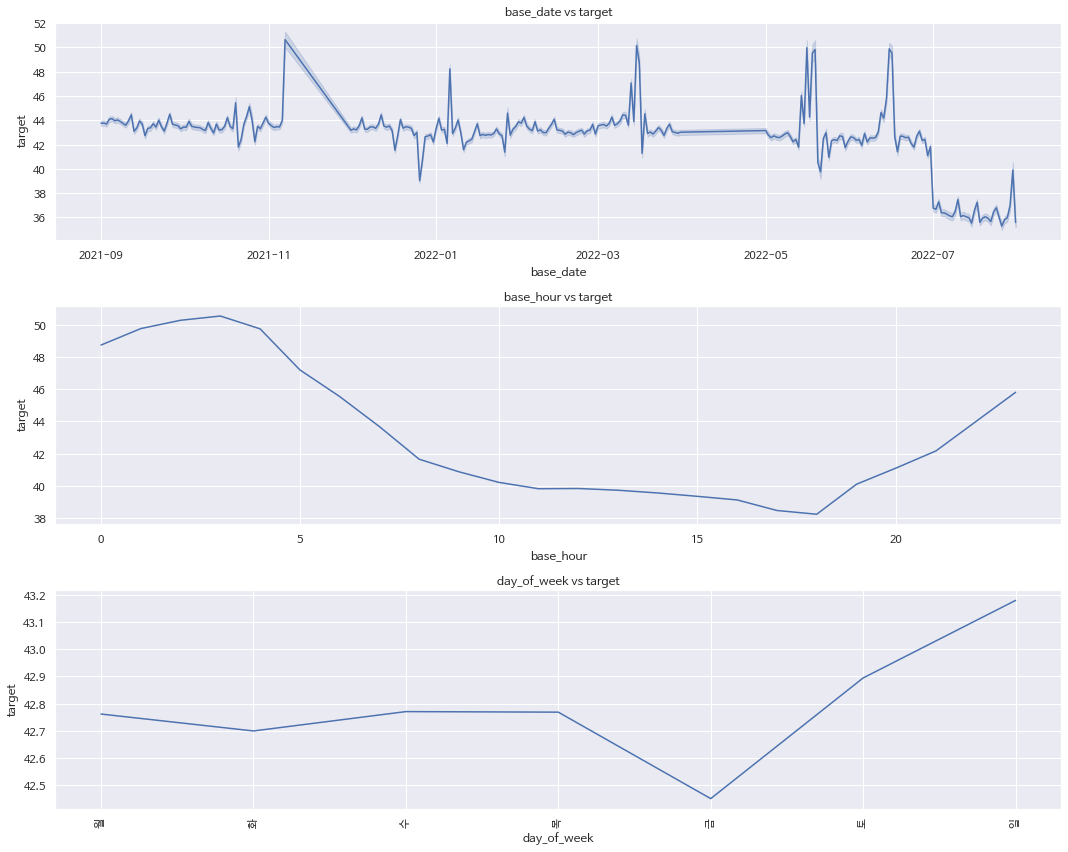

In [13]:
### 시각화
fig, axes = plt.subplots(3, figsize=(15,12))

sns.lineplot(x='base_date',y='target',data=train_df,ax=axes[0]).set(title='base_date vs target')
sns.lineplot(x='base_hour',y='target',data=train_time,ax=axes[1]).set(title='base_hour vs target')
sns.lineplot(x='day_of_week',y='target',data=train_day,ax=axes[2]).set(title='day_of_week vs target')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


**시각화 결과**

- base_date  
2022년 7월 기준 교통량이 증가하였는데, 이는 2021년 코로나로 인하여 제주도 관광객이 없어 교통량이 적은 것으로 생각된다.

- base_hour  
00시-05시,18시-24시 교통량이 감소하고, 05시-18시 교통량 증가하며, 두 시간대의 차이가 크다.

- day_of_week  
금요일에 차량 평균 속도가 감소하는 것으로 보아, 교통량이 증가한다는 것을 알 수 있다. 그리고 주말 차량 평균 속도가 점차 증가하는 것을 보아 주말 교통량이 감소한다는 것을 알 수 있다. 하지만 큰 차이를 보이는 것 같진 않다.

---

## 04. Feature Engineering

**파생변수 생성 및 LabelEncoding**

In [13]:
### 년도
train_df['year'] = train_df['base_date'].dt.year
test_df['year'] = test_df['base_date'].dt.year

In [14]:
### 월
train_df['month'] = train_df['base_date'].dt.month
test_df['month'] = test_df['base_date'].dt.month

In [15]:
### 출발지-도착지 결합
train_df['combine_node_name'] = train_df['start_node_name'] + '-' + train_df['end_node_name']
test_df['combine_node_name'] = test_df['start_node_name'] + '-' + test_df['end_node_name']

In [16]:
### 요일, 도로명, 출발지-도착지, 시작 & 도착 지점의 회전제한 유무 LabelEncoder
from sklearn.preprocessing import LabelEncoder

str_col = ['day_of_week','road_name', 'combine_node_name',
           'start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder() # 문자를 숫자(수치화), 숫자를 문자로 매핑
    le=le.fit(train_df[i])
    train_df[i]=le.transform(train_df[i])
    
    for label in np.unique(test_df[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_df[i]=le.transform(test_df[i])

In [19]:
train_df

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year,month,combine_node_name
0,TRAIN_0000000,2022-06-23,1,17,0,1,106,46,0,0,...,126.662612,0,제3교래교,33.427749,126.662335,0,52.0,2022,6,632
1,TRAIN_0000001,2022-07-28,1,21,0,2,103,34,0,0,...,126.529107,1,KAL사거리,33.504811,126.526240,0,30.0,2022,7,57
2,TRAIN_0000002,2021-10-10,4,7,0,2,103,36,0,0,...,126.368598,0,상창육교,33.280072,126.362147,0,61.0,2021,10,704
3,TRAIN_0000003,2022-03-11,0,13,0,2,107,57,0,0,...,126.567204,0,서현주택,33.245565,126.566228,0,20.0,2022,3,99
4,TRAIN_0000004,2021-10-05,6,8,0,2,103,35,0,0,...,126.326551,0,애월입구,33.462677,126.330152,0,38.0,2021,10,433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,2021-11-04,1,16,0,1,107,0,0,0,...,126.278125,0,금덕해운,33.420955,126.273750,0,20.0,2021,11,132
4701213,TRAIN_4701213,2022-03-31,1,2,0,2,107,0,0,0,...,126.424368,0,광삼교,33.472525,126.424890,0,65.0,2022,3,55
4701214,TRAIN_4701214,2022-06-13,3,22,0,2,103,35,0,0,...,126.912579,0,성산교차로,33.444121,126.912948,0,30.0,2022,6,31
4701215,TRAIN_4701215,2021-10-20,2,2,0,2,103,37,0,0,...,126.431817,0,관광대학입구,33.444996,126.433332,0,73.0,2021,10,643


**결측치 처리**

train set과 test set에 결측값이 존재하지 않는다

In [20]:
train_df.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
road_in_use              0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
year                     0
month                    0
combine_node_name        0
dtype: int64

In [21]:
test_df.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
road_in_use              0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
year                     0
month                    0
combine_node_name        0
dtype: int64

**변수들 간의 상관관계**

- 독립변수와의 관계  

road_type 변수와 weight_restricted 변수의 상관계수가 0.79로 서로 크게 영향을 끼친다는 것을 알 수 있다.

- 종속변수(target)과의 관계

target 변수에 대한 상관관계가 가장 높은 변수
  1. maximum_speed_limit(0.43)
  2. weight_restricted (0.29)
  3. road_type(0.2)


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


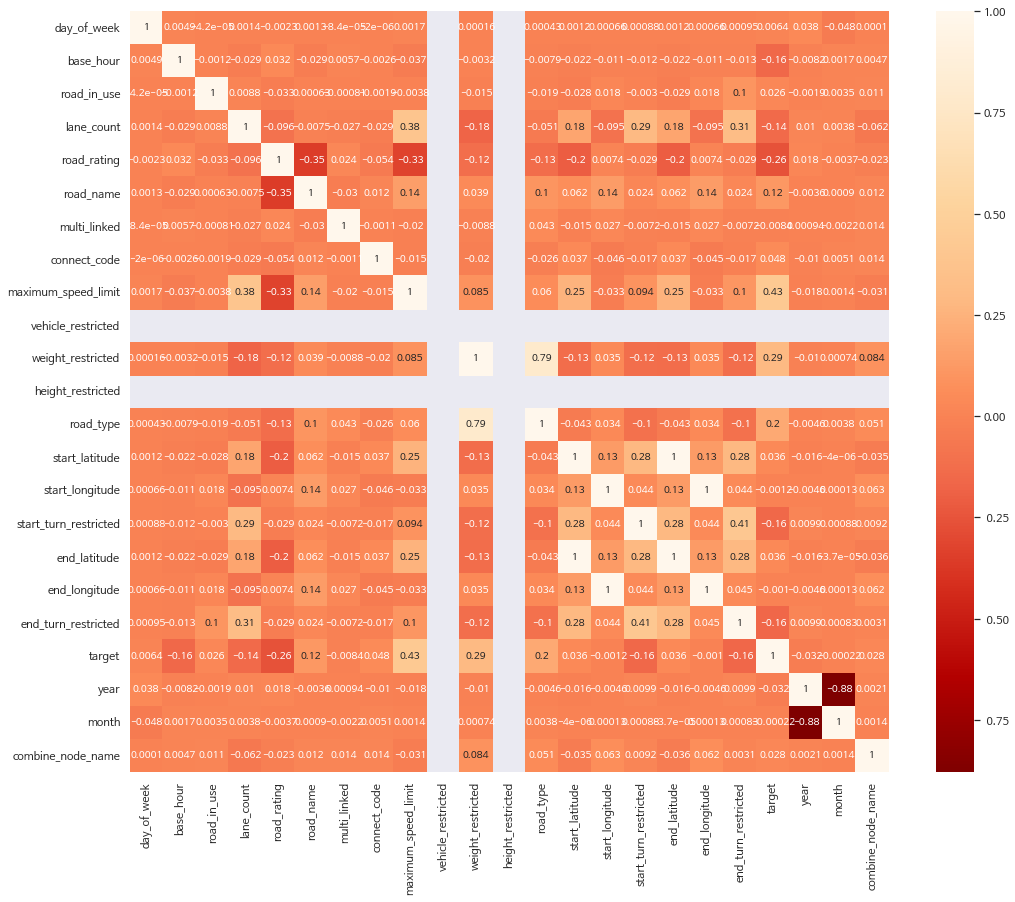

In [ ]:
fig, ax = plt.subplots(figsize=(17,14))
sns.heatmap(train_df.corr(), annot=True, annot_kws={"size": 10}, cmap='OrRd_r');

---

## 05. Data Preprocessing

In [22]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
### 모델링에 사용되지 않는 변수 제거
train.drop(['id','start_node_name', 'end_node_name', 'start_turn_restricted','end_turn_restricted','base_date'], axis = 1, inplace = True)
test.drop(['id','start_node_name', 'end_node_name', 'start_turn_restricted','end_turn_restricted','base_date'], axis = 1, inplace = True)

In [ ]:
### X_train, y_train 설정
y_train = train['target'] 
X_train = train.drop(['target'], axis=1)

print("X_train set shape : ",X_train.shape)
print("y_train set shape : ",y_train.shape)
print("test set shape : ",test.shape)

X_train set shape :  (4701217, 20)
y_train set shape :  (4701217,)
test set shape :  (291241, 20)


**Feature Scaling**

- StandardScaler  
  : 평균이 0이고 분산이 1인 정규 분포로 만드는 것이다.
  
  : 정규분포를 만들 때 쓰는 공식과 같다.

  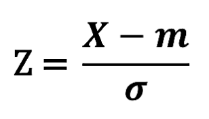




- 방법  
  : 먼저 객체를 생성하여 학습시킨다. 그리고 그 안에 데이터를 집어 넣어서 transfrom을 한다. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
test.loc[:, :] = scaler.transform(test)

test.head(2)

,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,year,month,combine_node_name
0,-0.991029,0.754498,-0.036936,1.691525,1.109446,0.047421,-0.021829,-0.050886,0.72087,0.0,-0.402678,0.0,-0.507917,1.137435,0.125438,1.150794,0.141615,0.804187,0.450723,-0.598548
1,1.506502,0.010682,-0.036936,0.237511,-1.064340,0.227714,-0.021829,-0.050886,0.72087,0.0,-0.402678,0.0,1.968826,-1.243157,-0.605507,-1.247087,-0.677032,0.804187,0.450723,1.152501


**Train-Test Split**

- 사이킷런(scikit-learn)의 model_selection 패키지 안에 train_test_split 모듈을 활용하여 손쉽게 train set(학습 데이터 셋)과 test set(테스트 셋)을 분리

- OverFitting을 방지하기 위해 사용(train set / validation set / test set)  
  - 예측율이나 오차율이 떨어지는 현상을 확인하기 위함

**코드 설명**

- startify(계층적 데이터 추출 옵션)

  : 여러 층으로 분할후 각 층별로 렌덤 데이터 추출, 원래 데이터의 분포와 유사하게 데이터 추출

- random_state

  : 호출할 때마다 동일한 학습/테스트용 데이터 세트를 생성하기 위해 주어지는 난수 값

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                            stratify=train['base_hour'], random_state=2021)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(3760973, 20) (3760973,)
(940244, 20) (940244,)


---

## 06. Modeling

#### Regression MLP

- 선형적 계층을 연결하여 input layer, hidden layer, output layer의 크게 세 가지 층을 가진다.

- 회귀문제의 경우 출력층을 선형 회귀구조를 사용한다.

- 장점
  - 대량의 데이터에 내재된 정보를 잘 잡아낸다.
  - 매우 복잡한 모델을 만들 수 있다.(non-linear layer가 있기에 가능한 것)
  - 충분한 연산 시간과 데이터를 주고 hyper-parameter를 잘 조정하면 뛰어난 성능을 낼 수 있다.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
X_tr.shape[1:]

(20,)

##### 1st Modeling


**01. 모델 만들기**

은닉층 1개(뉴런 수는 30)와 출력층 1개로 구성된 MLP를 Sequential API로 구축한다.

- Sequential : 순차적으로 레이어 층을 더해주기 때문에 순차모델이라고 한다. 아주 쉽고, 1개입력과 1개출력으로 계속 처리한다. 70%의 경우 적용이 가능하다.

- 활성화 함수, RELU : 값이 사라지거나 그대로 전달하게 하는 식으로 미분이 아주 잘 작동한다. 이러한 특징으로 인해 최적화가 더 잘 되고, vanishing gradient 문제를 줄여준다.

**02. 컴파일**

학습을 하기 전에 학습에 필요한 구조를 내부적으로 만든다

In [ ]:
# 모델 설계
mlp_model = keras.models.Sequential([
    # loss를 떨어뜨리기 위해서 값(keras.layers.Dense(`30`,...)을 높이거나 낮출수 있다.
    keras.layers.Dense(30, 
                       activation="relu", 
                       input_shape=X_tr.shape[1:]), 
    keras.layers.Dense(1)
])

# 컴파일
mlp_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))


In [ ]:
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 30)                630       
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


**03. 모델학습**
 


In [ ]:
# 모델 학습
history = mlp_model.fit(X_tr, y_tr, 
                    epochs=20, 
                    validation_data=(X_val, y_val))

Epoch 1/20
117531/117531 [==============================] - 165s 1ms/step - loss: 94.9128 - val_loss: 89.0955
Epoch 2/20
117531/117531 [==============================] - 149s 1ms/step - loss: 84.3878 - val_loss: 81.7645
Epoch 3/20
117531/117531 [==============================] - 166s 1ms/step - loss: 82.4649 - val_loss: 79.9436
Epoch 4/20
117531/117531 [==============================] - 136s 1ms/step - loss: 82.0363 - val_loss: 79.6168
Epoch 5/20
117531/117531 [==============================] - 158s 1ms/step - loss: 81.7263 - val_loss: 88.8669
Epoch 6/20
117531/117531 [==============================] - 155s 1ms/step - loss: 81.6160 - val_loss: 80.9959
Epoch 7/20
117531/117531 [==============================] - 141s 1ms/step - loss: 81.4278 - val_loss: 80.3120
Epoch 8/20
117531/117531 [==============================] - 134s 1ms/step - loss: 81.2399 - val_loss: 106.5019
Epoch 9/20
117531/117531 [==============================] - 137s 1ms/step - loss: 81.1297 - val_loss: 87.3110
Epoch 10/

In [ ]:
### 성능 측정 - MAE
from sklearn.metrics import mean_absolute_error
print(f"Train set: {mean_absolute_error(y_tr, mlp_model.predict(X_tr))}")
print(f"Validation set: {mean_absolute_error(y_val, mlp_model.predict(X_val))}")

117531/117531 [==============================] - 98s 832us/step
Train set: 6.852871951196929
29383/29383 [==============================] - 24s 832us/step
Validation set: 6.851315356818881


**04. 모델예측**


In [ ]:
### 예측
pred_2 = mlp_model.predict(test)
len(pred_2)

9102/9102 [==============================] - 7s 820us/step


291241

##### Hyperparameter Tuning

: 많은 하이퍼파라미터 조합을 시도하여 어떤 조합이 주어진 문제에서 최적인지 알아보고자 한다.

: 어떤 것이 검증 세트에서 가장 좋은 점수를 내는지 확인하는 것이다.

: RandomizedSearchCV 를 사용해 하이퍼파라미터 공간을 탐색해볼 것이다.

In [ ]:
# 모델 설계
def build_model(n_hidden=1, n_neurons=30):
  mlp_model2 = keras.models.Sequential()
  for layer in range(n_hidden):
    mlp_model2.add(keras.layers.Dense(n_neurons, activation='relu'))
  mlp_model2.add(keras.layers.Dense(1))
  mlp_model2.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
  return mlp_model2

- KerasRegressor 객체를 만들면 일반적인 사이킷런 회귀 추정기처럼 사용할 수 있다.

In [ ]:
# build_model() 함수로 만들어진 케라스 모델을 감싸는 간단한 wrapper
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model) 

<ipython-input-25-14637e303c4f>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [ ]:
# build_model() 함수로 만들어진 케라스 모델을 감싸는 간단한 wrapper
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model) 

keras_reg.fit(X_tr, y_tr, epochs=10,
              validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
117531/117531 [==============================] - 204s 2ms/step - loss: 82.9664 - val_loss: 74.4346
Epoch 2/10
117531/117531 [==============================] - 204s 2ms/step - loss: 74.0841 - val_loss: 70.9275
Epoch 3/10
117531/117531 [==============================] - 197s 2ms/step - loss: 73.1330 - val_loss: 69.6771
Epoch 4/10
117531/117531 [==============================] - 190s 2ms/step - loss: 72.9637 - val_loss: 96.0490
Epoch 5/10
117531/117531 [==============================] - 190s 2ms/step - loss: 72.7352 - val_loss: 77.3896
Epoch 6/10
117531/117531 [==============================] - 204s 2ms/step - loss: 72.5037 - val_loss: 73.7089
Epoch 7/10
117531/117531 [==============================] - 203s 2ms/step - loss: 72.4227 - val_loss: 74.0314
Epoch 8/10
117531/117531 [==============================] - 189s 2ms/step - loss: 72.3377 - val_loss: 83.4290
Epoch 9/10
117531/117531 [==============================] - 190s 2ms/step - loss: 72.1725 - val_loss: 73.6220
Epoch 10/1

- RandomizedSearchCV

: 각 반복마다 임의의 값만 대입해 지정한 횟수만큼 평가한다.

:  하이퍼파라미터가 많으므로 그리드 탐색보단 랜덤 탐색을 사용하였다.

사용한 주요 매개변수

- param_distributions : 하이퍼파라미터 목록을 dictionary 로 전달

- n_iter : 파라미터 검색 횟수

- cv : 교차검증 시 fold 개수


In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden': [1, 2],
    'n_neurons': [20]
}

# RandomizedSearchCV 는 k-겹 교차 검증을 사용하기 때문에 X_val와 y_val를 사용하지 않는다.(조기 종료에만 사용)
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_tr, y_tr, epochs=10,
                  validation_data=(X_val, y_val),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 147s 2ms/step - loss: 113.1778 - val_loss: 110.3276
Epoch 2/10
78354/78354 [==============================] - 149s 2ms/step - loss: 109.9148 - val_loss: 110.0599
Epoch 3/10
78354/78354 [==============================] - 134s 2ms/step - loss: 108.1345 - val_loss: 108.0146
Epoch 4/10
78354/78354 [==============================] - 148s 2ms/step - loss: 107.4580 - val_loss: 106.8607
Epoch 5/10
78354/78354 [==============================] - 135s 2ms/step - loss: 107.3691 - val_loss: 108.0149
Epoch 6/10
78354/78354 [==============================] - 133s 2ms/step - loss: 107.2463 - val_loss: 108.8128
Epoch 7/10
78354/78354 [==============================] - 149s 2ms/step - loss: 107.1259 - val_loss: 106.5805
Epoch 8/10
78354/78354 [==============================] - 147s 2ms/step - loss: 107.0565 - val_loss: 107.7139
Epoch 9/10
78354/78354 [==============================] - 149s 2ms/step - loss: 106.9917 - val_loss: 106.8365
Epoch 10/1

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 147s 2ms/step - loss: 83.9464 - val_loss: 76.8361
Epoch 2/10
78354/78354 [==============================] - 146s 2ms/step - loss: 76.5585 - val_loss: 75.6464
Epoch 3/10
78354/78354 [==============================] - 135s 2ms/step - loss: 76.0315 - val_loss: 75.3325
Epoch 4/10
78354/78354 [==============================] - 134s 2ms/step - loss: 75.5749 - val_loss: 79.3093
Epoch 5/10
78354/78354 [==============================] - 134s 2ms/step - loss: 75.4849 - val_loss: 75.2253
Epoch 6/10
78354/78354 [==============================] - 132s 2ms/step - loss: 75.3812 - val_loss: 73.5331
Epoch 7/10
78354/78354 [==============================] - 140s 2ms/step - loss: 75.1834 - val_loss: 78.4107
Epoch 8/10
78354/78354 [==============================] - 130s 2ms/step - loss: 75.0637 - val_loss: 74.6914
Epoch 9/10
78354/78354 [==============================] - 141s 2ms/step - loss: 74.9155 - val_loss: 75.7534
Epoch 10/10
39177/39177 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 146s 2ms/step - loss: 113.4445 - val_loss: 110.3436
Epoch 2/10
78354/78354 [==============================] - 148s 2ms/step - loss: 110.7065 - val_loss: 111.6622
Epoch 3/10
78354/78354 [==============================] - 159s 2ms/step - loss: 110.5905 - val_loss: 110.3678
Epoch 4/10
78354/78354 [==============================] - 152s 2ms/step - loss: 110.5178 - val_loss: 111.6882
Epoch 5/10
78354/78354 [==============================] - 160s 2ms/step - loss: 110.4526 - val_loss: 110.0546
Epoch 6/10
78354/78354 [==============================] - 156s 2ms/step - loss: 110.1366 - val_loss: 109.1720
Epoch 7/10
78354/78354 [==============================] - 155s 2ms/step - loss: 110.0630 - val_loss: 110.0286
Epoch 8/10
78354/78354 [==============================] - 158s 2ms/step - loss: 109.8222 - val_loss: 109.8925
Epoch 9/10
78354/78354 [==============================] - 140s 2ms/step - loss: 109.2346 - val_loss: 110.1244
Epoch 10/1

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 147s 2ms/step - loss: 73.3548 - val_loss: 62.2117
Epoch 2/10
78354/78354 [==============================] - 149s 2ms/step - loss: 60.7207 - val_loss: 59.8240
Epoch 3/10
78354/78354 [==============================] - 161s 2ms/step - loss: 59.0282 - val_loss: 56.9609
Epoch 4/10
78354/78354 [==============================] - 153s 2ms/step - loss: 57.7955 - val_loss: 55.6065
Epoch 5/10
78354/78354 [==============================] - 170s 2ms/step - loss: 57.0437 - val_loss: 55.6238
Epoch 6/10
78354/78354 [==============================] - 152s 2ms/step - loss: 56.6094 - val_loss: 68.7594
Epoch 7/10
78354/78354 [==============================] - 162s 2ms/step - loss: 56.1612 - val_loss: 70.2771
Epoch 8/10
78354/78354 [==============================] - 170s 2ms/step - loss: 55.6803 - val_loss: 54.1137
Epoch 9/10
78354/78354 [==============================] - 167s 2ms/step - loss: 55.2591 - val_loss: 53.3111
Epoch 10/10
39177/39177 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 169s 2ms/step - loss: 71.1281 - val_loss: 69.1366
Epoch 2/10
78354/78354 [==============================] - 154s 2ms/step - loss: 60.9522 - val_loss: 62.0524
Epoch 3/10
78354/78354 [==============================] - 153s 2ms/step - loss: 58.9523 - val_loss: 56.2559
Epoch 4/10
78354/78354 [==============================] - 151s 2ms/step - loss: 57.1814 - val_loss: 57.2520
Epoch 5/10
78354/78354 [==============================] - 155s 2ms/step - loss: 55.9757 - val_loss: 54.7068
Epoch 6/10
78354/78354 [==============================] - 166s 2ms/step - loss: 55.2448 - val_loss: 53.7488
Epoch 7/10
78354/78354 [==============================] - 165s 2ms/step - loss: 54.7176 - val_loss: 58.2805
Epoch 8/10
78354/78354 [==============================] - 157s 2ms/step - loss: 54.0929 - val_loss: 52.2966
Epoch 9/10
78354/78354 [==============================] - 163s 2ms/step - loss: 53.4405 - val_loss: 59.4531
Epoch 10/10
39177/39177 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 156s 2ms/step - loss: 69.7667 - val_loss: 59.0373
Epoch 2/10
78354/78354 [==============================] - 176s 2ms/step - loss: 59.4049 - val_loss: 57.2545
Epoch 3/10
78354/78354 [==============================] - 156s 2ms/step - loss: 57.5467 - val_loss: 57.8899
Epoch 4/10
78354/78354 [==============================] - 163s 2ms/step - loss: 56.4035 - val_loss: 57.3507
Epoch 5/10
78354/78354 [==============================] - 156s 2ms/step - loss: 55.5069 - val_loss: 60.2379
Epoch 6/10
78354/78354 [==============================] - 168s 2ms/step - loss: 54.9052 - val_loss: 55.0003
Epoch 7/10
78354/78354 [==============================] - 168s 2ms/step - loss: 54.4203 - val_loss: 52.9127
Epoch 8/10
78354/78354 [==============================] - 169s 2ms/step - loss: 54.1656 - val_loss: 56.0153
Epoch 9/10
78354/78354 [==============================] - 168s 2ms/step - loss: 53.8846 - val_loss: 53.2224
Epoch 10/10
39177/39177 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
117531/117531 [==============================] - 240s 2ms/step - loss: 70.4167 - val_loss: 62.3439
Epoch 2/10
117531/117531 [==============================] - 245s 2ms/step - loss: 60.8633 - val_loss: 62.4554
Epoch 3/10
117531/117531 [==============================] - 233s 2ms/step - loss: 58.0733 - val_loss: 60.2367
Epoch 4/10
117531/117531 [==============================] - 241s 2ms/step - loss: 56.3042 - val_loss: 58.4134
Epoch 5/10
117531/117531 [==============================] - 241s 2ms/step - loss: 55.2306 - val_loss: 55.5936
Epoch 6/10
117531/117531 [==============================] - 224s 2ms/step - loss: 54.6735 - val_loss: 52.9883
Epoch 7/10
117531/117531 [==============================] - 230s 2ms/step - loss: 54.3452 - val_loss: 57.7695
Epoch 8/10
117531/117531 [==============================] - 238s 2ms/step - loss: 53.8311 - val_loss: 56.0140
Epoch 9/10
117531/117531 [==============================] - 232s 2ms/step - loss: 53.3399 - val_loss: 66.6614
Epoch 10/1

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff466fbc820>,
                   param_distributions={'n_hidden': [1, 2], 'n_neurons': [20]})

In [ ]:
# 모든 파라미터의 조합을 rank_test_score 순으로 정렬하여 출력
pd.DataFrame(rnd_search_cv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neurons,param_n_hidden,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,1628.323101,28.741432,73.911286,11.807205,20,2,"{'n_neurons': 20, 'n_hidden': 2}",-56.158710,-62.643715,-62.574207,-60.458878,3.040810,1
0,1478.257655,82.157698,62.065881,14.620891,20,1,"{'n_neurons': 20, 'n_hidden': 1}",-106.074974,-86.398117,-108.063118,-100.178736,9.778114,2


##### 2nd Modeling

In [ ]:
# 모델 설계
def build_model_hp(n_hidden=2, n_neurons=20):
  mlp_model3 = keras.models.Sequential()
  for layer in range(n_hidden):
    mlp_model3.add(keras.layers.Dense(n_neurons, activation='relu'))
  mlp_model3.add(keras.layers.Dense(1))
  mlp_model3.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
  return mlp_model3

In [ ]:
# build_model() 함수로 만들어진 케라스 모델을 감싸는 간단한 wrapper
keras_reg_hp = keras.wrappers.scikit_learn.KerasRegressor(build_model_hp) 

<ipython-input-30-eb33919724a9>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg_hp = keras.wrappers.scikit_learn.KerasRegressor(build_model_hp)


In [ ]:
keras_reg_hp.fit(X_tr, y_tr, epochs=10,
              validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
117531/117531 [==============================] - 243s 2ms/step - loss: 67.1018 - val_loss: 58.1277
Epoch 2/10
117531/117531 [==============================] - 237s 2ms/step - loss: 58.9420 - val_loss: 68.2732
Epoch 3/10
117531/117531 [==============================] - 235s 2ms/step - loss: 57.1877 - val_loss: 54.8277
Epoch 4/10
117531/117531 [==============================] - 229s 2ms/step - loss: 55.9816 - val_loss: 55.1492
Epoch 5/10
117531/117531 [==============================] - 227s 2ms/step - loss: 55.1618 - val_loss: 55.7734
Epoch 6/10
117531/117531 [==============================] - 232s 2ms/step - loss: 54.3433 - val_loss: 52.6354
Epoch 7/10
117531/117531 [==============================] - 232s 2ms/step - loss: 53.6776 - val_loss: 56.9948
Epoch 8/10
117531/117531 [==============================] - 231s 2ms/step - loss: 52.9580 - val_loss: 53.2381
Epoch 9/10
117531/117531 [==============================] - 224s 2ms/step - loss: 52.4716 - val_loss: 67.5355
Epoch 10/1

In [ ]:
### 성능 측정 - MAE
from sklearn.metrics import mean_absolute_error
print(f"Train set: {mean_absolute_error(y_tr, keras_reg_hp.predict(X_tr))}")
print(f"Validation set: {mean_absolute_error(y_val, keras_reg_hp.predict(X_val))}")

117531/117531 [==============================] - 161s 1ms/step
Train set: 5.554514810317918
29383/29383 [==============================] - 40s 1ms/step
Validation set: 5.54597515369777


In [ ]:
### 예측
pred_2_1 = keras_reg_hp.predict(test)
len(pred_2_1)

9102/9102 [==============================] - 13s 1ms/step


291241

- **성능 측정 결과**

하이퍼파라미터 튜닝 전(1차 모델링) 모델 성능은 **약 6.8**로 측정되었고,

```
117531/117531 [==============================] - 98s 832us/step
Train set: 6.852871951196929
29383/29383 [==============================] - 24s 832us/step
Validation set: 6.851315356818881
```

하이퍼파라미터 튜닝 후(2차 모델링) 모델 성능은 **약 5.5** 로 측정되었다.

```
117531/117531 [==============================] - 161s 1ms/step
Train set: 5.554514810317918
29383/29383 [==============================] - 40s 1ms/step
Validation set: 5.54597515369777
```

하이퍼파라미터 튜닝을 진행했을 때, **약 1.3** 정도 모델 성능이 향상되었다.



##### 3nd Modeling

- input 변수 다시 설정
- 하이퍼파라미터 튜닝 - 파라미터 종류 재 설정
- 성능 측정

**데이터 전처리**

In [17]:
train_2 = train_df.copy()
test_2 = test_df.copy()

### 모델링에 사용되지 않는 변수 제거
train_2.drop(['id','start_node_name', 'end_node_name', 'start_turn_restricted','end_turn_restricted','base_date', 'multi_linked', 'connect_code','weight_restricted','start_latitude','start_longitude','road_name'], axis = 1, inplace = True)
test_2.drop(['id','start_node_name', 'end_node_name', 'start_turn_restricted','end_turn_restricted','base_date', 'multi_linked', 'connect_code','weight_restricted','start_latitude','start_longitude','road_name'], axis = 1, inplace = True)

### X_train, y_train 설정
y_train_2 = train_2['target'] 
X_train_2 = train_2.drop(['target'], axis=1)

print("X_train set shape : ",X_train_2.shape)
print("y_train set shape : ",y_train_2.shape)
print("test set shape : ",test_2.shape)

X_train set shape :  (4701217, 14)
y_train set shape :  (4701217,)
test set shape :  (291241, 14)


In [18]:
### Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train_2)
X_train_2.loc[:, :] = scaler.transform(X_train_2)
test_2.loc[:, :] = scaler.transform(test_2)

test_2.head(2)

,day_of_week,base_hour,road_in_use,lane_count,road_rating,maximum_speed_limit,vehicle_restricted,height_restricted,road_type,end_latitude,end_longitude,year,month,combine_node_name
0,-0.991029,0.754498,-0.036936,1.691525,1.109446,0.72087,0.0,0.0,-0.507917,1.150794,0.141615,0.804187,0.450723,-0.598548
1,1.506502,0.010682,-0.036936,0.237511,-1.064340,0.72087,0.0,0.0,1.968826,-1.247087,-0.677032,0.804187,0.450723,1.152501


In [19]:
### Train-Test Split
from sklearn.model_selection import train_test_split
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_train_2, y_train_2, test_size=0.2, 
                                            stratify=train_2['base_hour'], random_state=2021)

print(X_tr2.shape, y_tr2.shape)
print(X_val2.shape, y_val2.shape)

(3760973, 14) (3760973,)
(940244, 14) (940244,)


In [20]:
### Modeling
import tensorflow as tf
from tensorflow import keras
import sklearn

np.random.seed(42)
tf.random.set_seed(42)

In [21]:
# 모델 설계
def build_model(n_hidden=1, n_neurons=30):
  mlp_model2 = keras.models.Sequential()
  for layer in range(n_hidden):
    mlp_model2.add(keras.layers.Dense(n_neurons, activation='relu'))
  mlp_model2.add(keras.layers.Dense(1))
  mlp_model2.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
  return mlp_model2

In [22]:
# build_model() 함수로 만들어진 케라스 모델을 감싸는 간단한 wrapper
keras_reg_2 = keras.wrappers.scikit_learn.KerasRegressor(build_model) 

<ipython-input-22-85e66e6baed5>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg_2 = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [23]:
# build_model() 함수로 만들어진 케라스 모델을 감싸는 간단한 wrapper
keras_reg_2 = keras.wrappers.scikit_learn.KerasRegressor(build_model) 

keras_reg_2.fit(X_tr2, y_tr2, epochs=10,
              validation_data=(X_val2, y_val2),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

<ipython-input-23-b63c51db514f>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg_2 = keras.wrappers.scikit_learn.KerasRegressor(build_model)
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
117531/117531 [==============================] - 193s 2ms/step - loss: 88.6661 - val_loss: 79.5417
Epoch 2/10
117531/117531 [==============================] - 200s 2ms/step - loss: 79.6318 - val_loss: 77.3342
Epoch 3/10
117531/117531 [==============================] - 199s 2ms/step - loss: 79.4144 - val_loss: 91.6207
Epoch 4/10
117531/117531 [==============================] - 197s 2ms/step - loss: 79.2142 - val_loss: 82.3267
Epoch 5/10
117531/117531 [==============================] - 197s 2ms/step - loss: 78.9914 - val_loss: 80.9664
Epoch 6/10
117531/117531 [==============================] - 202s 2ms/step - loss: 78.9559 - val_loss: 78.4333
Epoch 7/10
117531/117531 [==============================] - 190s 2ms/step - loss: 78.6629 - val_loss: 84.9296
Epoch 8/10
117531/117531 [==============================] - 197s 2ms/step - loss: 78.6372 - val_loss: 90.9345
Epoch 9/10
117531/117531 [==============================] - 184s 2ms/step - loss: 78.6914 - val_loss: 93.5376
Epoch 10/1

In [ ]:
### 랜덤 탐색
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden': [1, 2],
    'n_neurons': [20, 30]
}

# RandomizedSearchCV 는 k-겹 교차 검증을 사용하기 때문에 X_val와 y_val를 사용하지 않는다.(조기 종료에만 사용)
rnd_search_cv2 = RandomizedSearchCV(keras_reg_2, param_distribs, n_iter=10, cv=3)
rnd_search_cv2.fit(X_tr2, y_tr2, epochs=10,
                  validation_data=(X_val2, y_val2),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 135s 2ms/step - loss: 123.4411 - val_loss: 119.7034
Epoch 2/10
78354/78354 [==============================] - 136s 2ms/step - loss: 101.0649 - val_loss: 92.4297
Epoch 3/10
78354/78354 [==============================] - 145s 2ms/step - loss: 90.5562 - val_loss: 89.6672
Epoch 4/10
78354/78354 [==============================] - 135s 2ms/step - loss: 89.9157 - val_loss: 88.0888
Epoch 5/10
78354/78354 [==============================] - 147s 2ms/step - loss: 88.6295 - val_loss: 88.7945
Epoch 6/10
78354/78354 [==============================] - 146s 2ms/step - loss: 88.3637 - val_loss: 87.1511
Epoch 7/10
78354/78354 [==============================] - 134s 2ms/step - loss: 88.2924 - val_loss: 87.2544
Epoch 8/10
78354/78354 [==============================] - 148s 2ms/step - loss: 88.2163 - val_loss: 93.7268
Epoch 9/10
78354/78354 [==============================] - 146s 2ms/step - loss: 88.1986 - val_loss: 87.7355
Epoch 10/10
39177/39177 [

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 140s 2ms/step - loss: 92.2252 - val_loss: 85.0460
Epoch 2/10
78354/78354 [==============================] - 146s 2ms/step - loss: 84.6645 - val_loss: 83.0397
Epoch 3/10
78354/78354 [==============================] - 135s 2ms/step - loss: 82.1012 - val_loss: 84.0295
Epoch 4/10
78354/78354 [==============================] - 135s 2ms/step - loss: 81.4538 - val_loss: 86.6703
Epoch 5/10
78354/78354 [==============================] - 146s 2ms/step - loss: 81.3395 - val_loss: 83.0529
Epoch 6/10
78354/78354 [==============================] - 148s 2ms/step - loss: 81.2867 - val_loss: 79.1023
Epoch 7/10
78354/78354 [==============================] - 136s 2ms/step - loss: 81.2891 - val_loss: 84.6833
Epoch 8/10
78354/78354 [==============================] - 146s 2ms/step - loss: 81.2603 - val_loss: 82.2050
Epoch 9/10
78354/78354 [==============================] - 134s 2ms/step - loss: 81.2718 - val_loss: 84.1117
Epoch 10/10
39177/39177 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 137s 2ms/step - loss: 113.1638 - val_loss: 96.3638
Epoch 2/10
78354/78354 [==============================] - 134s 2ms/step - loss: 93.2652 - val_loss: 89.8372
Epoch 3/10
78354/78354 [==============================] - 136s 2ms/step - loss: 90.1008 - val_loss: 88.6765
Epoch 4/10
78354/78354 [==============================] - 135s 2ms/step - loss: 89.6421 - val_loss: 88.5004
Epoch 5/10
78354/78354 [==============================] - 134s 2ms/step - loss: 89.6363 - val_loss: 95.8045
Epoch 6/10
78354/78354 [==============================] - 148s 2ms/step - loss: 89.6195 - val_loss: 100.7816
Epoch 7/10
78354/78354 [==============================] - 149s 2ms/step - loss: 89.6004 - val_loss: 87.4807
Epoch 8/10
78354/78354 [==============================] - 136s 2ms/step - loss: 89.5794 - val_loss: 92.1522
Epoch 9/10
78354/78354 [==============================] - 146s 2ms/step - loss: 89.6251 - val_loss: 88.6642
Epoch 10/10
39177/39177 [=

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


78354/78354 [==============================] - 147s 2ms/step - loss: 84.1204 - val_loss: 76.6236
Epoch 2/10
78354/78354 [==============================] - 148s 2ms/step - loss: 74.3037 - val_loss: 75.8091
Epoch 3/10
78354/78354 [==============================] - 135s 2ms/step - loss: 73.7863 - val_loss: 73.3067
Epoch 4/10
78354/78354 [==============================] - 146s 2ms/step - loss: 73.6785 - val_loss: 71.2790
Epoch 5/10
78354/78354 [==============================] - 134s 2ms/step - loss: 73.6428 - val_loss: 76.0792
Epoch 6/10
78354/78354 [==============================] - 148s 2ms/step - loss: 73.4175 - val_loss: 76.6251
Epoch 7/10
78354/78354 [==============================] - 148s 2ms/step - loss: 73.2433 - val_loss: 75.2083
Epoch 8/10
78354/78354 [==============================] - 134s 2ms/step - loss: 73.2239 - val_loss: 75.6979
Epoch 9/10
78354/78354 [==============================] - 148s 2ms/step - loss: 73.1729 - val_loss: 70.9264
Epoch 10/10
39177/39177 [==============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


78354/78354 [==============================] - 137s 2ms/step - loss: 93.5901 - val_loss: 83.8082
Epoch 2/10
78354/78354 [==============================] - 146s 2ms/step - loss: 81.6750 - val_loss: 80.4444
Epoch 3/10
78354/78354 [==============================] - 147s 2ms/step - loss: 79.6251 - val_loss: 78.5037
Epoch 4/10
78354/78354 [==============================] - 148s 2ms/step - loss: 79.0661 - val_loss: 79.9665
Epoch 5/10
78354/78354 [==============================] - 136s 2ms/step - loss: 79.0229 - val_loss: 77.8625
Epoch 6/10
78354/78354 [==============================] - 146s 2ms/step - loss: 78.9829 - val_loss: 77.4053
Epoch 7/10
78354/78354 [==============================] - 136s 2ms/step - loss: 78.9536 - val_loss: 83.3749
Epoch 8/10
78354/78354 [==============================] - 136s 2ms/step - loss: 78.9626 - val_loss: 79.5397
Epoch 9/10
78354/78354 [==============================] - 146s 2ms/step - loss: 78.9769 - val_loss: 77.5073
Epoch 10/10
39177/39177 [==============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


78354/78354 [==============================] - 134s 2ms/step - loss: 102.5657 - val_loss: 85.1184
Epoch 2/10
78354/78354 [==============================] - 148s 2ms/step - loss: 85.4455 - val_loss: 83.2548
Epoch 3/10
78354/78354 [==============================] - 149s 2ms/step - loss: 83.9205 - val_loss: 81.6431
Epoch 4/10
78354/78354 [==============================] - 137s 2ms/step - loss: 82.2381 - val_loss: 83.2292
Epoch 5/10
78354/78354 [==============================] - 147s 2ms/step - loss: 81.8567 - val_loss: 92.9232
Epoch 6/10
78354/78354 [==============================] - 149s 2ms/step - loss: 81.8306 - val_loss: 83.1442
Epoch 7/10
78354/78354 [==============================] - 136s 2ms/step - loss: 81.7809 - val_loss: 79.7985
Epoch 8/10
78354/78354 [==============================] - 147s 2ms/step - loss: 81.7307 - val_loss: 83.0748
Epoch 9/10
78354/78354 [==============================] - 147s 2ms/step - loss: 81.7250 - val_loss: 88.3101
Epoch 10/10
39177/39177 [=============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 152s 2ms/step - loss: 76.7109 - val_loss: 68.9530
Epoch 2/10
78354/78354 [==============================] - 139s 2ms/step - loss: 65.7357 - val_loss: 60.7331
Epoch 3/10
78354/78354 [==============================] - 140s 2ms/step - loss: 62.8846 - val_loss: 60.0773
Epoch 4/10
78354/78354 [==============================] - 150s 2ms/step - loss: 61.5578 - val_loss: 60.7070
Epoch 5/10
78354/78354 [==============================] - 152s 2ms/step - loss: 60.6900 - val_loss: 60.1676
Epoch 6/10
78354/78354 [==============================] - 140s 2ms/step - loss: 60.2403 - val_loss: 62.8379
Epoch 7/10
78354/78354 [==============================] - 150s 2ms/step - loss: 59.6949 - val_loss: 72.5248
Epoch 8/10
78354/78354 [==============================] - 150s 2ms/step - loss: 59.3252 - val_loss: 57.9839
Epoch 9/10
78354/78354 [==============================] - 152s 2ms/step - loss: 58.9713 - val_loss: 57.5319
Epoch 10/10
39177/39177 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 146s 2ms/step - loss: 76.8763 - val_loss: 68.7368
Epoch 2/10
78354/78354 [==============================] - 142s 2ms/step - loss: 64.4405 - val_loss: 63.6241
Epoch 3/10
78354/78354 [==============================] - 151s 2ms/step - loss: 62.5612 - val_loss: 59.1466
Epoch 4/10
78354/78354 [==============================] - 151s 2ms/step - loss: 61.9451 - val_loss: 69.4714
Epoch 5/10
78354/78354 [==============================] - 141s 2ms/step - loss: 61.5271 - val_loss: 60.7755
Epoch 6/10
78354/78354 [==============================] - 141s 2ms/step - loss: 60.9676 - val_loss: 57.6715
Epoch 7/10
78354/78354 [==============================] - 150s 2ms/step - loss: 60.5871 - val_loss: 63.5563
Epoch 8/10
78354/78354 [==============================] - 153s 2ms/step - loss: 60.2356 - val_loss: 67.2853
Epoch 9/10
78354/78354 [==============================] - 140s 2ms/step - loss: 59.9989 - val_loss: 57.1014
Epoch 10/10
39177/39177 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 140s 2ms/step - loss: 76.9873 - val_loss: 63.3082
Epoch 2/10
78354/78354 [==============================] - 152s 2ms/step - loss: 64.5697 - val_loss: 62.7999
Epoch 3/10
78354/78354 [==============================] - 150s 2ms/step - loss: 62.7838 - val_loss: 60.5368
Epoch 4/10
78354/78354 [==============================] - 140s 2ms/step - loss: 61.6949 - val_loss: 59.9105
Epoch 5/10
78354/78354 [==============================] - 140s 2ms/step - loss: 60.8076 - val_loss: 63.5152
Epoch 6/10
78354/78354 [==============================] - 138s 2ms/step - loss: 60.1759 - val_loss: 59.2837
Epoch 7/10
78354/78354 [==============================] - 152s 2ms/step - loss: 59.8039 - val_loss: 56.5397
Epoch 8/10
78354/78354 [==============================] - 151s 2ms/step - loss: 59.6001 - val_loss: 65.0579
Epoch 9/10
78354/78354 [==============================] - 151s 2ms/step - loss: 59.3291 - val_loss: 64.6437
Epoch 10/10
39177/39177 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78354/78354 [==============================] - 145s 2ms/step - loss: 71.9805 - val_loss: 63.1521
Epoch 2/10
78354/78354 [==============================] - 141s 2ms/step - loss: 58.9872 - val_loss: 55.3935
Epoch 3/10
78354/78354 [==============================] - 154s 2ms/step - loss: 55.8455 - val_loss: 54.8112
Epoch 4/10
78354/78354 [==============================] - 153s 2ms/step - loss: 54.3698 - val_loss: 52.3910
Epoch 5/10
78354/78354 [==============================] - 153s 2ms/step - loss: 53.4021 - val_loss: 52.3774
Epoch 6/10
78354/78354 [==============================] - 154s 2ms/step - loss: 52.6699 - val_loss: 53.5257
Epoch 7/10
78354/78354 [==============================] - 152s 2ms/step - loss: 52.0770 - val_loss: 51.7445
Epoch 8/10
78354/78354 [==============================] - 143s 2ms/step - loss: 51.5967 - val_loss: 53.8817
Epoch 9/10
78354/78354 [==============================] - 141s 2ms/step - loss: 51.1972 - val_loss: 49.8496
Epoch 10/10
39177/39177 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
78327/78354 [============================>.] - ETA: 0s - loss: 69.4104

In [ ]:
# 모든 파라미터의 조합을 rank_test_score 순으로 정렬하여 출력
pd.DataFrame(rnd_search_cv.cv_results_).sort_values('rank_test_score')

In [ ]:
### 성능 측정 - MAE
from sklearn.metrics import mean_absolute_error
print(f"Train set: {mean_absolute_error(y_tr2, rnd_search_cv2.predict(X_tr2))}")
print(f"Validation set: {mean_absolute_error(y_val2, rnd_search_cv2.predict(X_val2))}")

In [ ]:
### 예측
pred_2_2 = rnd_search_cv2.predict(test_2)
len(pred_2_2)

#### LightGBM Regressor 

- Light GBM은 Gradient Boosting 프레워크로 Tree 기반 학습 알고리즘이다.

  - Tree가 수직적으로 확장
  - leaf-wise : 동일한 leaf를 확장할 때, leaf-wise 알고리즘은 level-wise 알고리즘보다 더 많은 loss, 손실을 줄일수 있다.



* Light GBM 작동 방식

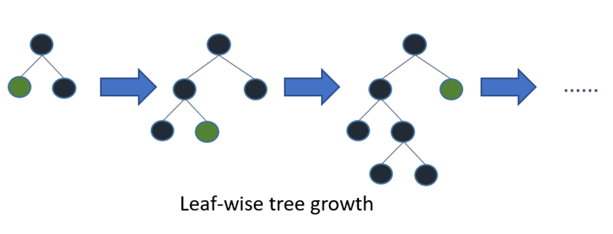

In [ ]:
import lightgbm as lgb
LR = lgb.LGBMRegressor(random_state=42).fit(X_tr, y_tr, 
                                            eval_set=[(X_val, y_val)],
                                            early_stopping_rounds=500)

y_pred = LR.predict(test)

[1]	valid_0's l2: 223.224
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's l2: 197.384
[3]	valid_0's l2: 176.344
[4]	valid_0's l2: 159.288
[5]	valid_0's l2: 145.178
[6]	valid_0's l2: 132.991
[7]	valid_0's l2: 122.769
[8]	valid_0's l2: 114.348
[9]	valid_0's l2: 107.081
[10]	valid_0's l2: 100.821
[11]	valid_0's l2: 95.7492
[12]	valid_0's l2: 91.2563
[13]	valid_0's l2: 87.5778
[14]	valid_0's l2: 84.1998
[15]	valid_0's l2: 81.1222
[16]	valid_0's l2: 78.5079
[17]	valid_0's l2: 76.1169
[18]	valid_0's l2: 73.9617
[19]	valid_0's l2: 72.1424
[20]	valid_0's l2: 70.5285
[21]	valid_0's l2: 68.9793
[22]	valid_0's l2: 67.4853
[23]	valid_0's l2: 66.1232
[24]	valid_0's l2: 64.673
[25]	valid_0's l2: 63.5771
[26]	valid_0's l2: 62.3423
[27]	valid_0's l2: 61.4634
[28]	valid_0's l2: 60.4681
[29]	valid_0's l2: 59.8507
[30]	valid_0's l2: 59.2794
[31]	valid_0's l2: 58.4542
[32]	valid_0's l2: 57.5288
[33]	valid_0's l2: 57.0073
[34]	valid_0's l2: 56.3274
[35]	valid_0's l2: 55.92
[36]

In [ ]:
### 성능 측정 - MAE
from sklearn.metrics import mean_absolute_error
print(f"Train set: {mean_absolute_error(y_tr, LR.predict(X_tr))}")
print(f"Validation set: {mean_absolute_error(y_val, LR.predict(X_val))}")

Train set: 4.722931740191671
Validation set: 4.722516669058208


**LGBM 모델의 변수 중요도**

LGBM 모델에서 주요 변수는 위치변수(start_longitude, start_latitude, end_longitude, end_latitude)이다.

그외 변수로는  도로 이름 변수(combine_node_name, road_name), 시간변수(base_hour)이 있다.

> target변수에 좌표(위치)가 가장 많은 영향을 미친 것을 알 수 있다

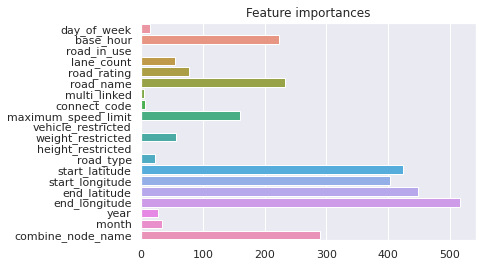

In [ ]:
# 영향을 많이 미치는 변수 확인
feature_names = X_train.columns
importances = LR.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

In [ ]:
pred = LR.predict(test)
len(pred)

291241

#### XGBoost

- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost 가 대표적

- 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리이다.

- Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋다.


In [ ]:
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

xgb_model = xgboost.XGBRegressor(n_estimators=100, 
                                learning_rate=0.08,
                                gamma=0,
                                subsample=0.75,
                                colsample_bytree=1, 
                                max_depth=7)

xgb_model.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='mae',
                verbose=100,
                early_stopping_rounds=200)

[06:50:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:38.9284
Will train until validation_0-mae hasn't improved in 200 rounds.
[99]	validation_0-mae:4.49532


XGBRegressor(learning_rate=0.08, max_depth=7, subsample=0.75)

**XGB 모델의 변수 중요도**

LGBM 모델에서 주요 변수는 시간변수(base_hour, month)이고, 위치변수(start_latitude, end_longitude, end_latitude) 또한 모델에서 중요한 변수에 속한다.

그외 변수에는 도로 이름 변수(combine_node_name)가 있다.

> target변수에 시간과 좌표(위치)가 가장 많은 영향을 미친 것을 알 수 있다

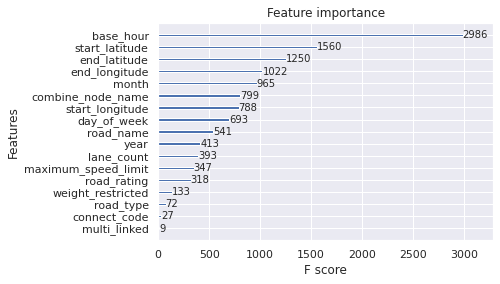

In [ ]:
# 영향을 많이 미치는 변수 확인
xgboost.plot_importance(xgb_model)

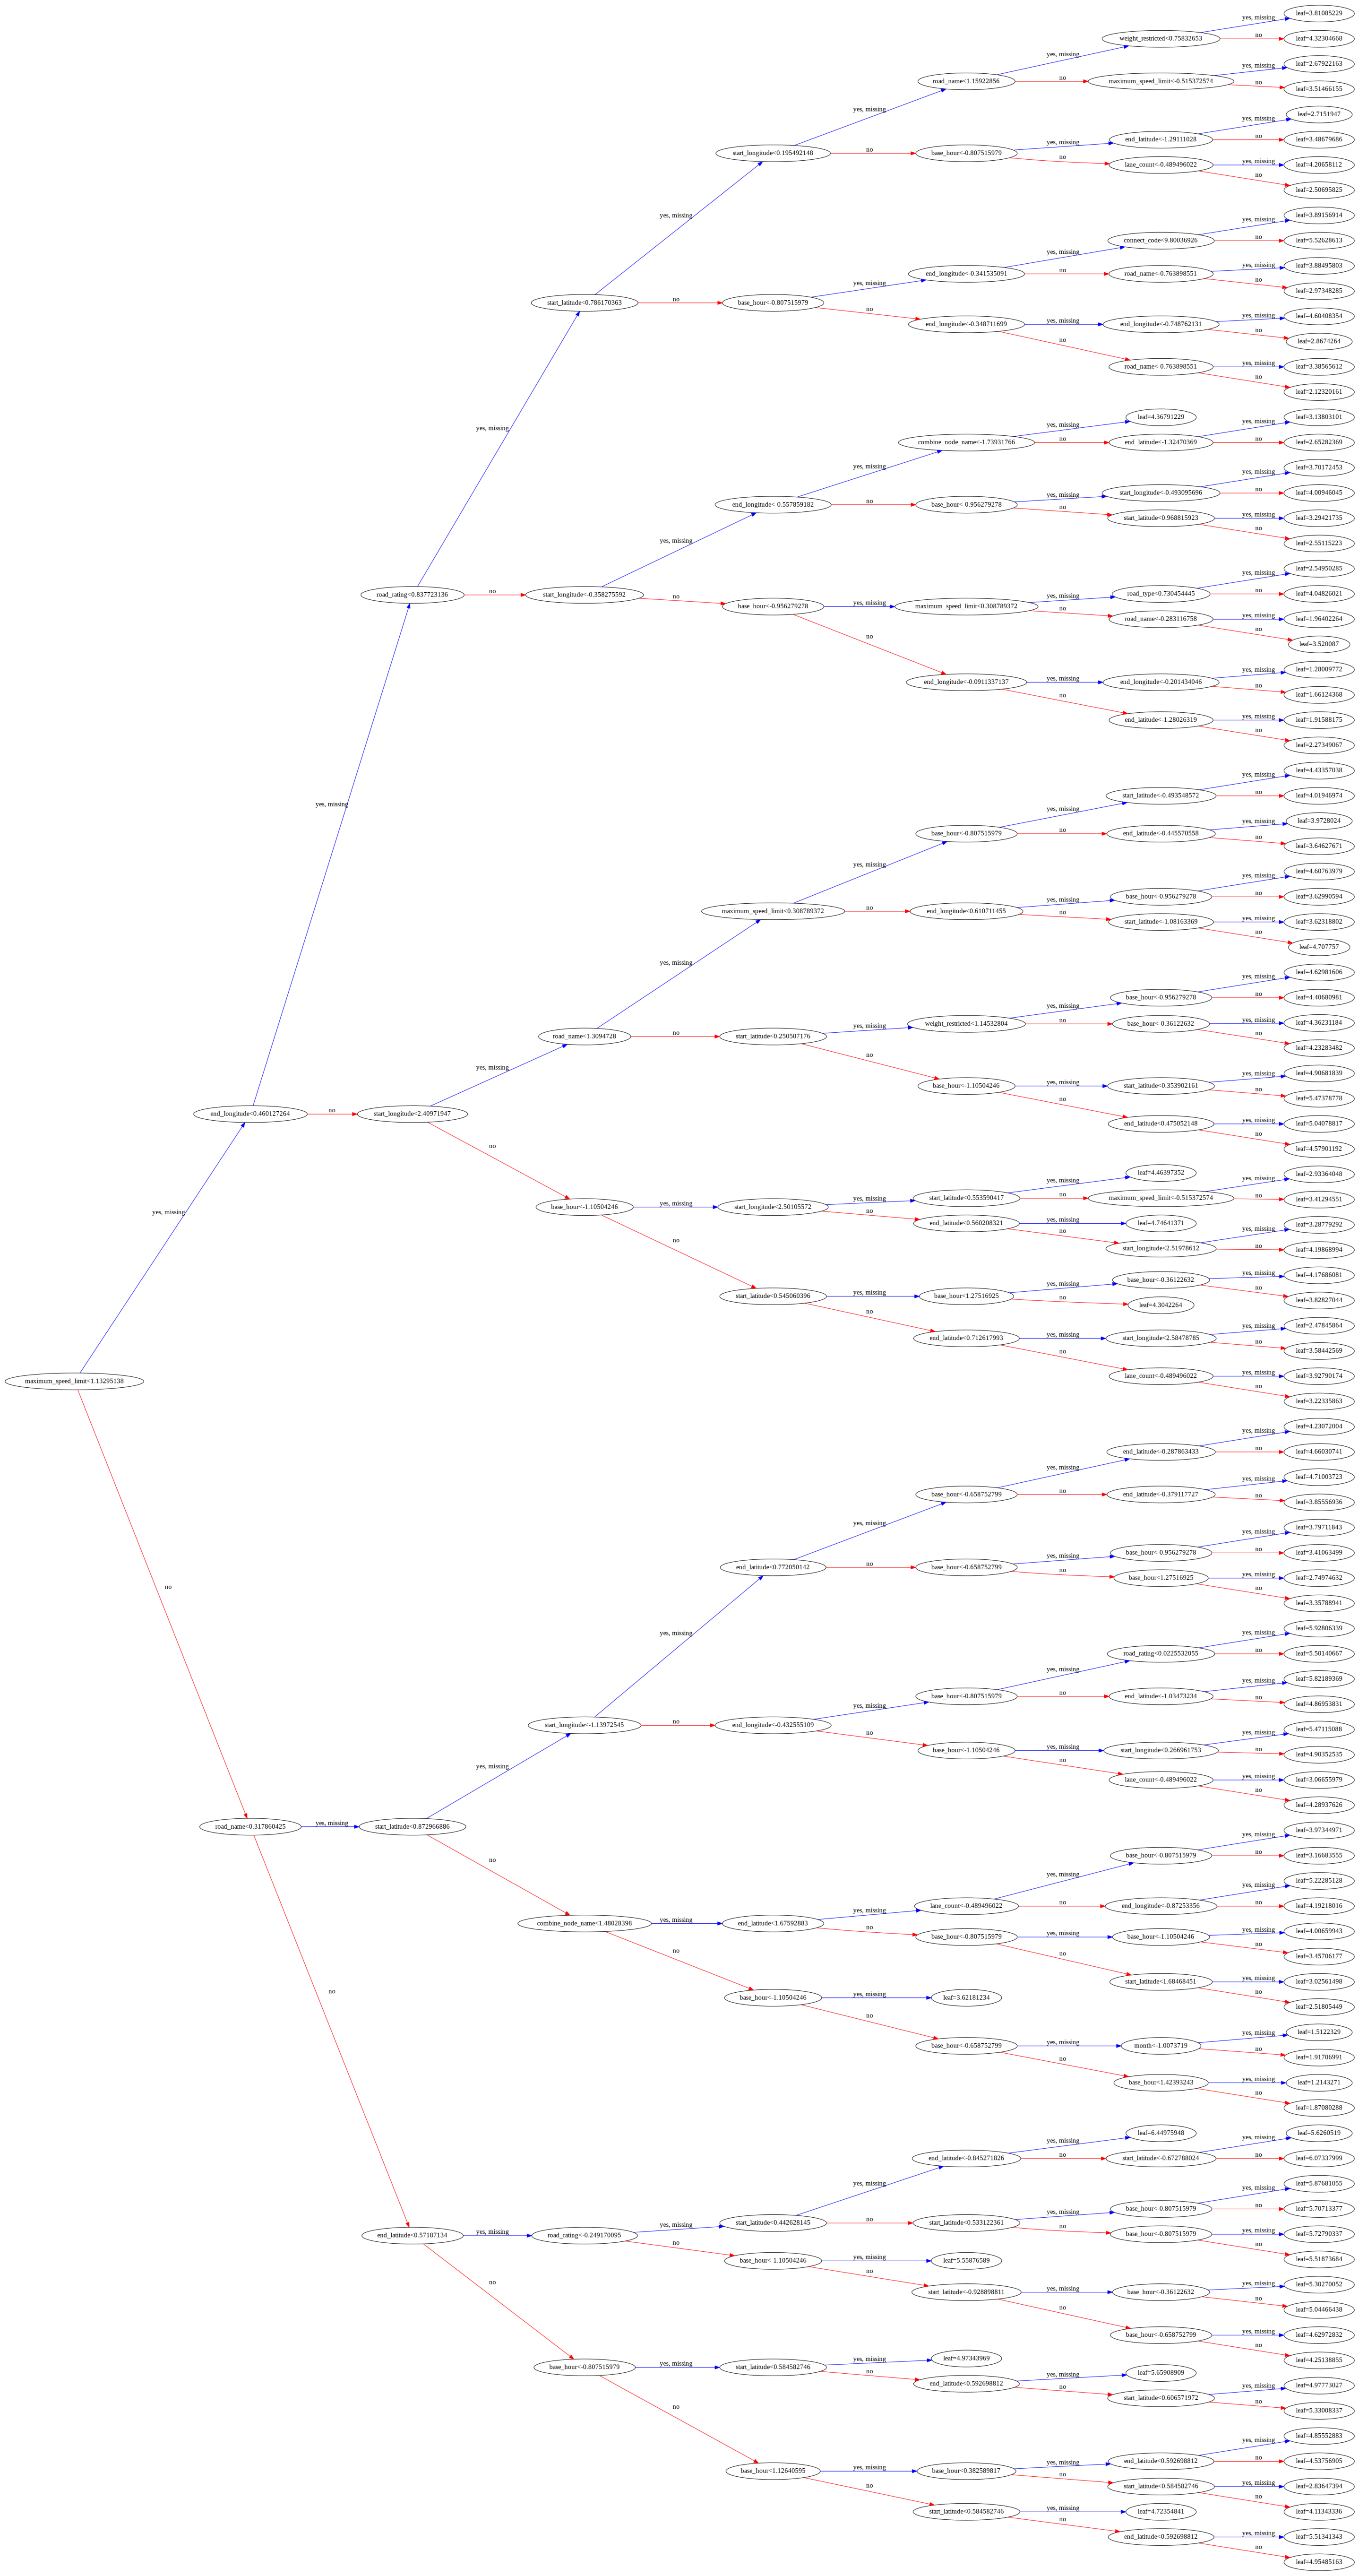

In [ ]:
### 의사결정트리 확인
import matplotlib.pyplot as plt
import xgboost

xgboost.plot_tree(xgb_model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(150, 100)

plt.show()

In [ ]:
### 성능 측정 - MAE
from sklearn.metrics import mean_absolute_error
print(f"Train set: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"Validation set: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")

Train set: 4.491776769283464
Validation set: 4.495317155978585


In [ ]:
pred_1 = xgb_model.predict(test)
len(pred_1)

291241

---

## 07. Modeling Result

**sample_submission.csv**

- id : 샘플 별 고유 id
- target : 도로의 차량 평균 속도(km)

In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/Competition/데이콘_제주도도로교통량예측AI경진대회/sample_submission.csv")
sample_submission.head()

,id,target
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0


##### 1. Regression MLP

- 하이퍼파라미터 튜닝 전 점수 : 6.4346841197

- 하이퍼파라미터 튜닝 후 점수 : 5.7320801849

In [ ]:
### 최적의 파라미터 탐색 전 - 6.4346841197
sub = sample_submission.copy()
sub['target'] = pred_2
sub

,id,target
0,TEST_000000,23.170517
1,TEST_000001,43.118088
2,TEST_000002,57.701950
3,TEST_000003,31.473175
4,TEST_000004,34.821121
...,...,...
291236,TEST_291236,42.059052
291237,TEST_291237,46.303894
291238,TEST_291238,21.870373
291239,TEST_291239,26.498802


In [ ]:
sub.to_csv("./submit_mlp.csv", index = False)

In [ ]:
### 최적의 파라미터 탐색 후 - 5.7320801849
sub1 = sample_submission.copy()
sub1['target'] = pred_2_1
sub1

,id,target
0,TEST_000000,30.406572
1,TEST_000001,43.566021
2,TEST_000002,63.411873
3,TEST_000003,30.706717
4,TEST_000004,38.716068
...,...,...
291236,TEST_291236,50.298531
291237,TEST_291237,51.172234
291238,TEST_291238,25.321882
291239,TEST_291239,21.815384


In [ ]:
sub1.to_csv("./submit_mlp_hp.csv", index = False)

##### 2. LightGBM Regressor 

점수 : 4.8717244493

In [ ]:
sub2 = sample_submission.copy()
sub2['target'] = pred
sub2

,id,target
0,TEST_000000,26.743652
1,TEST_000001,46.956359
2,TEST_000002,58.565270
3,TEST_000003,34.846451
4,TEST_000004,39.251228
...,...,...
291236,TEST_291236,51.414051
291237,TEST_291237,52.559016
291238,TEST_291238,21.905918
291239,TEST_291239,24.347385


In [ ]:
sub2.to_csv("./submit_lgb.csv", index = False)

##### 3. XGBoost

점수 : 4.7127481009

In [ ]:
sub3 = sample_submission.copy()
sub3['target'] = pred_1
sub3

,id,target
0,TEST_000000,25.595303
1,TEST_000001,46.072865
2,TEST_000002,60.817394
3,TEST_000003,34.132416
4,TEST_000004,38.165123
...,...,...
291236,TEST_291236,49.942055
291237,TEST_291237,52.693478
291238,TEST_291238,20.804377
291239,TEST_291239,24.614418


In [ ]:
sub3.to_csv("./submit_xgb.csv", index = False)

---

## 08. Competition Result

3가지 모델 중 가장 점수가 좋았던 모델인 XGBoost로 4.71274점을 얻어, 최종 388등을 하게 되었습니다.

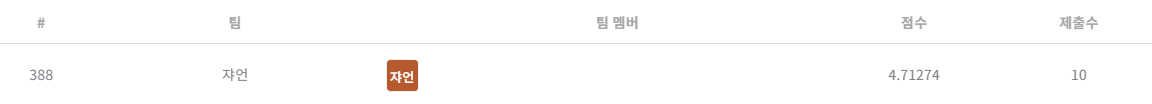